In [47]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [48]:
!pip list

Package                 Version
----------------------- --------
absl-py                 2.1.0
aiohttp                 3.9.5
aiosignal               1.2.0
asttokens               2.4.1
astunparse              1.6.3
async-timeout           4.0.3
attrs                   23.1.0
blinker                 1.6.2
Bottleneck              1.3.7
Brotli                  1.0.9
cachetools              5.3.3
certifi                 2024.2.2
cffi                    1.16.0
charset-normalizer      2.0.4
click                   8.1.7
colorama                0.4.6
comm                    0.2.2
contourpy               1.2.0
cryptography            41.0.3
cycler                  0.11.0
debugpy                 1.8.1
decorator               5.1.1
exceptiongroup          1.2.0
executing               2.0.1
flatbuffers             2.0
fonttools               4.51.0
frozenlist              1.4.0
gast                    0.4.0
google-auth             2.29.0
google-auth-oauthlib    0.4.4
google-pasta            0.2.

# Specify each path

In [49]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [50]:
NUM_CLASSES = 12

# Dataset reading

In [51]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [52]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [54]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [55]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 12)                132       
                                                                 
Total params: 1,202
Trainable params: 1,202
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [57]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [58]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[es_callback]
)

Epoch 1/1000
61/61 [==============================] - 0s 4ms/step - loss: 2.5370 - accuracy: 0.1075 - val_loss: 2.3611 - val_accuracy: 0.1894
Epoch 2/1000
61/61 [==============================] - 0s 2ms/step - loss: 2.3165 - accuracy: 0.1825 - val_loss: 2.1728 - val_accuracy: 0.2843
Epoch 3/1000
61/61 [==============================] - 0s 2ms/step - loss: 2.1248 - accuracy: 0.2690 - val_loss: 1.9124 - val_accuracy: 0.3079
Epoch 4/1000
61/61 [==============================] - 0s 2ms/step - loss: 1.8934 - accuracy: 0.3221 - val_loss: 1.6178 - val_accuracy: 0.4414
Epoch 5/1000
61/61 [==============================] - 0s 2ms/step - loss: 1.6916 - accuracy: 0.3508 - val_loss: 1.4280 - val_accuracy: 0.4796
Epoch 6/1000
61/61 [==============================] - 0s 2ms/step - loss: 1.5677 - accuracy: 0.3911 - val_loss: 1.3085 - val_accuracy: 0.5880
Epoch 7/1000
61/61 [==============================] - 0s 2ms/step - loss: 1.4786 - accuracy: 0.4172 - val_loss: 1.2052 - val_accuracy: 0.6512
Epoch 

In [59]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

21/21 [==============================] - 0s 804us/step - loss: 0.2968 - accuracy: 0.9626


In [60]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [61]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 51ms/step
[8.1468323e-07 4.2301067e-03 4.2986206e-04 9.8623997e-01 5.2362993e-06
 9.7120994e-14 4.9760987e-11 3.1806529e-08 8.6826449e-03 4.1131457e-04
 3.6531511e-20 1.3036534e-11]
3


# Confusion matrix

81/81 [==============================] - 0s 594us/step


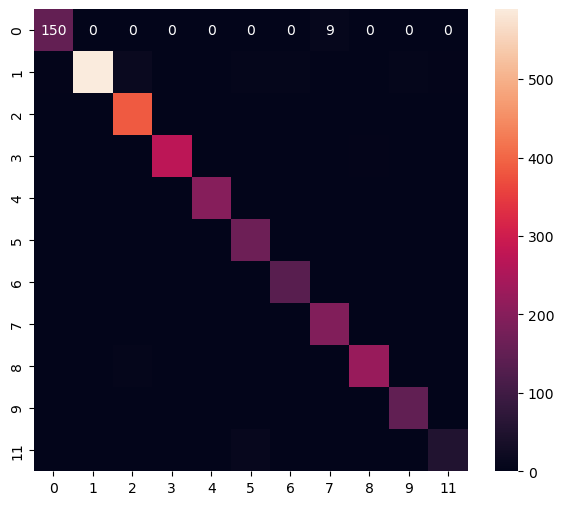

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       159
           1       1.00      0.93      0.97       630
           2       0.95      0.99      0.97       389
           3       0.99      0.99      0.99       275
           4       1.00      1.00      1.00       200
           5       0.91      0.99      0.95       166
           6       0.96      1.00      0.98       135
           7       0.95      1.00      0.97       193
           8       0.98      0.97      0.98       230
           9       0.96      0.99      0.97       151
          11       0.95      0.81      0.87        64

    accuracy                           0.97      2592
   macro avg       0.96      0.97      0.96      2592
weighted avg       0.97      0.97      0.97      2592



In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [63]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [64]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\acer\AppData\Local\Temp\tmps_oxtfa8\assets


INFO:tensorflow:Assets written to: C:\Users\acer\AppData\Local\Temp\tmps_oxtfa8\assets


6924

# Inference test

In [65]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [66]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [67]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [68]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [69]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.1468556e-07 4.2301109e-03 4.2986168e-04 9.8624009e-01 5.2363198e-06
 9.7121753e-14 4.9761088e-11 3.1806714e-08 8.6826496e-03 4.1131440e-04
 3.6531795e-20 1.3036633e-11]
3
